In [12]:
# Cell 1 - librerías e instrucciones (ejecutar)
# Si te faltan paquetes descomenta las líneas pip y ejecútalas (opcional).
# !pip install pandas numpy matplotlib seaborn scikit-learn

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

# configuración gráfica
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")


In [13]:

# Cargar directamente el dataset
data_file = "SpotifyFeatures.csv"

df = pd.read_csv(data_file, low_memory=False)
print("Cargando:", data_file)
print("Shape:", df.shape)
df.head()


Cargando: SpotifyFeatures.csv
Shape: (232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [14]:
# Exploración inicial
print(df.info())
print(df.describe().T.head(15))  # primeros 15 numéricas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [15]:
# Selección de columnas numéricas útiles para clustering
features = [
    "acousticness", "danceability", "energy", "instrumentalness", 
    "liveness", "loudness", "speechiness", "valence", 
    "tempo", "duration_ms", "popularity"
]

X = df[features].copy()
print("Features seleccionadas:", features)


Features seleccionadas: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'duration_ms', 'popularity']


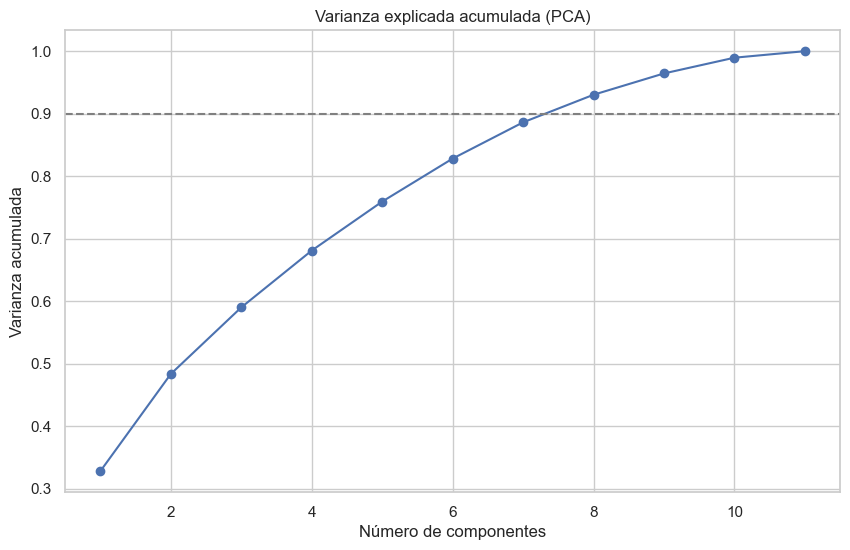

Componentes necesarios para 90% varianza: 8


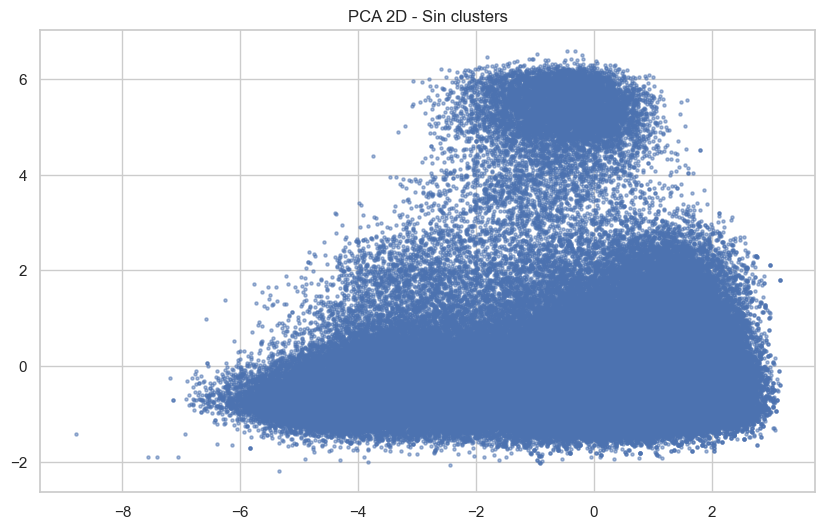

In [16]:
# Normalización (escalado estándar)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# reducción de dimensionalidad
pca_full = PCA().fit(X_scaled)
explained = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.axhline(0.9, color='gray', linestyle='--')
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.show()

n_comp = np.searchsorted(explained, 0.90) + 1
print("Componentes necesarios para 90% varianza:", n_comp)

# Para graficar en 2D
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_scaled)
df_pca2 = pd.DataFrame(X_pca2, columns=["PC1","PC2"])


# Visualización PCA 2D
plt.scatter(df_pca2["PC1"], df_pca2["PC2"], s=5, alpha=0.5)
plt.title("PCA 2D - Sin clusters")
plt.show()



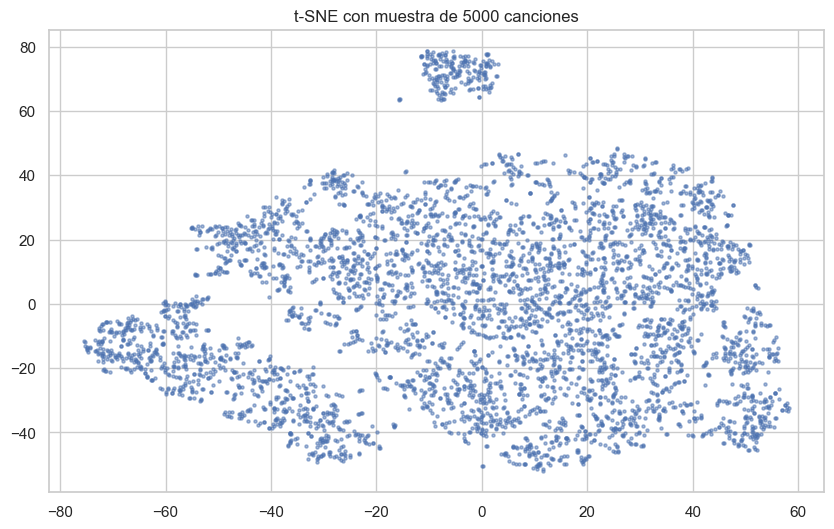

In [17]:
# Reducir el dataset a una muestra aleatoria de 5000 canciones
sample_df = df.sample(n=5000, random_state=42)
sample_X = sample_df[features]
sample_X_scaled = scaler.fit_transform(sample_X)

tsne = TSNE(n_components=2, random_state=42, learning_rate="auto", init="pca")
X_tsne = tsne.fit_transform(sample_X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], s=5, alpha=0.5)
plt.title("t-SNE con muestra de 5000 canciones")
plt.show()


k=2, silhouette=0.3189
k=3, silhouette=0.3445
k=4, silhouette=0.1602
k=5, silhouette=0.1501
k=6, silhouette=0.1360
k=7, silhouette=0.1415
k=8, silhouette=0.1474
k=9, silhouette=0.1530
k=10, silhouette=0.1536


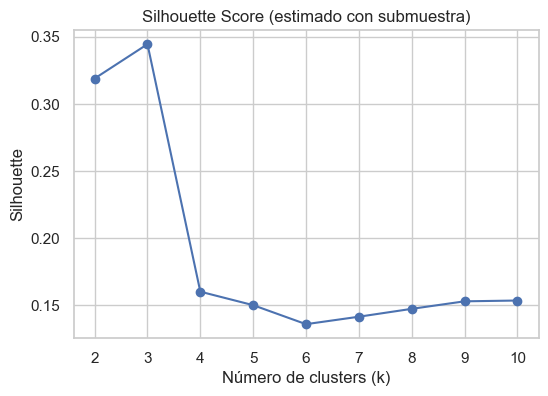

Mejor k estimado por silhouette: 3


In [24]:
sil_scores = []
K_range = range(2, 11)

# Submuestra para silhouette (indices relativos a sample_df)
idx_for_sil = np.random.choice(sample_X_scaled.shape[0], size=min(2000, sample_X_scaled.shape[0]), replace=False)
X_sub = sample_X_scaled[idx_for_sil]

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_full = km.fit_predict(sample_X_scaled)   # clustering sobre TODA la muestra
    sil = silhouette_score(X_sub, labels_full[idx_for_sil])
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.4f}")

plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette Score (estimado con submuestra)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")
plt.show()

best_k = list(K_range)[int(np.argmax(sil_scores))]
print("Mejor k estimado por silhouette:", best_k)

ValueError: 'c' argument has 5000 elements, which is inconsistent with 'x' and 'y' with size 232725.

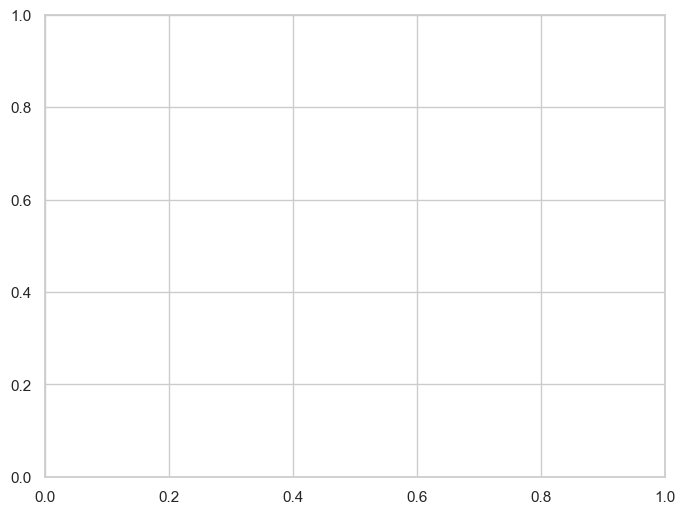

In [25]:
# ---------- Cell 10 - Ajuste final de KMeans (muestra de 5000) ----------
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
sample_df["kmeans_cluster"] = kmeans.fit_predict(sample_X_scaled)

clusters_int = sample_df["kmeans_cluster"].astype(int).to_numpy()

plt.figure(figsize=(8,6))
plt.scatter(df_pca2['PC1'], df_pca2['PC2'], c=clusters_int, cmap='tab10', s=8, alpha=0.6)
plt.title(f"KMeans clusters (k={best_k}) sobre PCA 2D (muestra)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

# Silhouette final sobre submuestra
idx2 = np.random.choice(sample_X_scaled.shape[0], size=min(2000, sample_X_scaled.shape[0]), replace=False)
print("Silhouette final (estimado):", silhouette_score(sample_X_scaled[idx2], clusters_int[idx2]))

